In [1]:
import zipfile
from zipfile import ZipFile
from io import BytesIO
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import lightgbm as lgb
from sklearn.svm import SVC
from IPython.display import display
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
pd.set_option('display.float_format', lambda x:'%.2f' % x)

今回は以下３点を重視してやっていく 
- まずはEDAを通じてルールベースで予測をすること
- lightGBMで有効な特徴量を算出すること
- ランダムフォレストでスコアを出す

In [2]:
train = pd.read_csv('../data/data_ex/house_credit/application_train.csv')
test = pd.read_csv('../data/data_ex/house_credit/application_test.csv')
bureau = pd.read_csv('../data/data_ex/house_credit/bureau.csv')
bureau_balance = pd.read_csv('../data/data_ex/house_credit/bureau_balance.csv')
credit_card_balance = pd.read_csv('../data/data_ex/house_credit/credit_card_balance.csv')
installments_payments = pd.read_csv('../data/data_ex/house_credit/installments_payments.csv')
previous_application = pd.read_csv('../data/data_ex/house_credit/previous_application.csv')
POS_CASH_balance = pd.read_csv('../data/data_ex/house_credit/POS_CASH_balance.csv')

In [3]:
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.00,406597.50,24700.50,...,0,0,0,0,0.00,0.00,0.00,0.00,0.00,1.00
1,100003,0,Cash loans,F,N,N,0,270000.00,1293502.50,35698.50,...,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00
2,100004,0,Revolving loans,M,Y,Y,0,67500.00,135000.00,6750.00,...,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00
3,100006,0,Cash loans,F,N,Y,0,135000.00,312682.50,29686.50,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.00,513000.00,21865.50,...,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00


In [4]:
train.columns.values

array(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE',
       'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE',
       'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE',
       'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START',
       'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION',
       'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
       'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
       'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_1',
       'EXT_SOURCE_2', 'EXT_SOURCE_3',

In [5]:
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.00,-153.00,NaN,0,91323.00,0.00,NaN,0.00,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.00,NaN,NaN,0,225000.00,171342.00,NaN,0.00,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.00,NaN,NaN,0,464323.50,NaN,NaN,0.00,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.00,NaN,NaN,0.00,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.00,NaN,77674.50,0,2700000.00,NaN,NaN,0.00,Consumer credit,-21,NaN


In [6]:
bureau.columns.values

array(['SK_ID_CURR', 'SK_ID_BUREAU', 'CREDIT_ACTIVE', 'CREDIT_CURRENCY',
       'DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE',
       'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE',
       'CNT_CREDIT_PROLONG', 'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT',
       'AMT_CREDIT_SUM_LIMIT', 'AMT_CREDIT_SUM_OVERDUE', 'CREDIT_TYPE',
       'DAYS_CREDIT_UPDATE', 'AMT_ANNUITY'], dtype=object)

In [7]:
bureau_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [8]:
credit_card_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.97,135000,0.00,877.50,0.00,877.50,1700.33,...,0.00,0.00,0.00,1,0.00,1.00,35.00,Active,0,0
1,2582071,363914,-1,63975.56,45000,2250.00,2250.00,0.00,0.00,2250.00,...,64875.56,64875.56,1.00,1,0.00,0.00,69.00,Active,0,0
2,1740877,371185,-7,31815.22,450000,0.00,0.00,0.00,0.00,2250.00,...,31460.08,31460.08,0.00,0,0.00,0.00,30.00,Active,0,0
3,1389973,337855,-4,236572.11,225000,2250.00,2250.00,0.00,0.00,11795.76,...,233048.97,233048.97,1.00,1,0.00,0.00,10.00,Active,0,0
4,1891521,126868,-1,453919.46,450000,0.00,11547.00,0.00,11547.00,22924.89,...,453919.46,453919.46,0.00,1,0.00,1.00,101.00,Active,0,0


In [9]:
credit_card_balance.columns.values

array(['SK_ID_PREV', 'SK_ID_CURR', 'MONTHS_BALANCE', 'AMT_BALANCE',
       'AMT_CREDIT_LIMIT_ACTUAL', 'AMT_DRAWINGS_ATM_CURRENT',
       'AMT_DRAWINGS_CURRENT', 'AMT_DRAWINGS_OTHER_CURRENT',
       'AMT_DRAWINGS_POS_CURRENT', 'AMT_INST_MIN_REGULARITY',
       'AMT_PAYMENT_CURRENT', 'AMT_PAYMENT_TOTAL_CURRENT',
       'AMT_RECEIVABLE_PRINCIPAL', 'AMT_RECIVABLE',
       'AMT_TOTAL_RECEIVABLE', 'CNT_DRAWINGS_ATM_CURRENT',
       'CNT_DRAWINGS_CURRENT', 'CNT_DRAWINGS_OTHER_CURRENT',
       'CNT_DRAWINGS_POS_CURRENT', 'CNT_INSTALMENT_MATURE_CUM',
       'NAME_CONTRACT_STATUS', 'SK_DPD', 'SK_DPD_DEF'], dtype=object)

In [10]:
installments_payments.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.00,6,-1180.00,-1187.00,6948.36,6948.36
1,1330831,151639,0.00,34,-2156.00,-2156.00,1716.53,1716.53
2,2085231,193053,2.00,1,-63.00,-63.00,25425.00,25425.00
3,2452527,199697,1.00,3,-2418.00,-2426.00,24350.13,24350.13
4,2714724,167756,1.00,2,-1383.00,-1366.00,2165.04,2160.59


In [11]:
installments_payments.columns.values

array(['SK_ID_PREV', 'SK_ID_CURR', 'NUM_INSTALMENT_VERSION',
       'NUM_INSTALMENT_NUMBER', 'DAYS_INSTALMENT', 'DAYS_ENTRY_PAYMENT',
       'AMT_INSTALMENT', 'AMT_PAYMENT'], dtype=object)

In [12]:
previous_application.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.43,17145.00,17145.00,0.00,17145.00,SATURDAY,15,...,Connectivity,12.00,middle,POS mobile with interest,365243.00,-42.00,300.00,-42.00,-37.00,0.00
1,2802425,108129,Cash loans,25188.62,607500.00,679671.00,NaN,607500.00,THURSDAY,11,...,XNA,36.00,low_action,Cash X-Sell: low,365243.00,-134.00,916.00,365243.00,365243.00,1.00
2,2523466,122040,Cash loans,15060.74,112500.00,136444.50,NaN,112500.00,TUESDAY,11,...,XNA,12.00,high,Cash X-Sell: high,365243.00,-271.00,59.00,365243.00,365243.00,1.00
3,2819243,176158,Cash loans,47041.33,450000.00,470790.00,NaN,450000.00,MONDAY,7,...,XNA,12.00,middle,Cash X-Sell: middle,365243.00,-482.00,-152.00,-182.00,-177.00,1.00
4,1784265,202054,Cash loans,31924.40,337500.00,404055.00,NaN,337500.00,THURSDAY,9,...,XNA,24.00,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
previous_application.columns.values

array(['SK_ID_PREV', 'SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'AMT_ANNUITY',
       'AMT_APPLICATION', 'AMT_CREDIT', 'AMT_DOWN_PAYMENT',
       'AMT_GOODS_PRICE', 'WEEKDAY_APPR_PROCESS_START',
       'HOUR_APPR_PROCESS_START', 'FLAG_LAST_APPL_PER_CONTRACT',
       'NFLAG_LAST_APPL_IN_DAY', 'RATE_DOWN_PAYMENT',
       'RATE_INTEREST_PRIMARY', 'RATE_INTEREST_PRIVILEGED',
       'NAME_CASH_LOAN_PURPOSE', 'NAME_CONTRACT_STATUS', 'DAYS_DECISION',
       'NAME_PAYMENT_TYPE', 'CODE_REJECT_REASON', 'NAME_TYPE_SUITE',
       'NAME_CLIENT_TYPE', 'NAME_GOODS_CATEGORY', 'NAME_PORTFOLIO',
       'NAME_PRODUCT_TYPE', 'CHANNEL_TYPE', 'SELLERPLACE_AREA',
       'NAME_SELLER_INDUSTRY', 'CNT_PAYMENT', 'NAME_YIELD_GROUP',
       'PRODUCT_COMBINATION', 'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE',
       'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE', 'DAYS_TERMINATION',
       'NFLAG_INSURED_ON_APPROVAL'], dtype=object)

In [14]:
POS_CASH_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.00,45.00,Active,0,0
1,1715348,367990,-33,36.00,35.00,Active,0,0
2,1784872,397406,-32,12.00,9.00,Active,0,0
3,1903291,269225,-35,48.00,42.00,Active,0,0
4,2341044,334279,-35,36.00,35.00,Active,0,0


In [15]:
POS_CASH_balance.columns.values

array(['SK_ID_PREV', 'SK_ID_CURR', 'MONTHS_BALANCE', 'CNT_INSTALMENT',
       'CNT_INSTALMENT_FUTURE', 'NAME_CONTRACT_STATUS', 'SK_DPD',
       'SK_DPD_DEF'], dtype=object)

全データの全容を確認したので、欠損データについてその数を見ていく

In [16]:
#まずは欠損データを見つけていく
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).reset_index()

In [17]:
#欠損率が高いデータはルールベースでは使わない方がよさそう　lightGBMで念のため見る
missing_data(train).head(10)

,index,Total,Percent
0,COMMONAREA_MEDI,214865,69.87
1,COMMONAREA_AVG,214865,69.87
2,COMMONAREA_MODE,214865,69.87
3,NONLIVINGAPARTMENTS_MODE,213514,69.43
4,NONLIVINGAPARTMENTS_AVG,213514,69.43
5,NONLIVINGAPARTMENTS_MEDI,213514,69.43
6,FONDKAPREMONT_MODE,210295,68.39
7,LIVINGAPARTMENTS_MODE,210199,68.35
8,LIVINGAPARTMENTS_AVG,210199,68.35
9,LIVINGAPARTMENTS_MEDI,210199,68.35


In [18]:
missing_data(test).head(10)

,index,Total,Percent
0,COMMONAREA_AVG,33495,68.72
1,COMMONAREA_MODE,33495,68.72
2,COMMONAREA_MEDI,33495,68.72
3,NONLIVINGAPARTMENTS_AVG,33347,68.41
4,NONLIVINGAPARTMENTS_MODE,33347,68.41
5,NONLIVINGAPARTMENTS_MEDI,33347,68.41
6,FONDKAPREMONT_MODE,32797,67.28
7,LIVINGAPARTMENTS_AVG,32780,67.25
8,LIVINGAPARTMENTS_MODE,32780,67.25
9,LIVINGAPARTMENTS_MEDI,32780,67.25


In [19]:
missing_data(bureau).head(10)

,index,Total,Percent
0,AMT_ANNUITY,1226791,71.47
1,AMT_CREDIT_MAX_OVERDUE,1124488,65.51
2,DAYS_ENDDATE_FACT,633653,36.92
3,AMT_CREDIT_SUM_LIMIT,591780,34.48
4,AMT_CREDIT_SUM_DEBT,257669,15.01
5,DAYS_CREDIT_ENDDATE,105553,6.15
6,AMT_CREDIT_SUM,13,0.00
7,CREDIT_ACTIVE,0,0.00
8,CREDIT_CURRENCY,0,0.00
9,DAYS_CREDIT,0,0.00


In [20]:
missing_data(bureau_balance).head(10)

,index,Total,Percent
0,SK_ID_BUREAU,0,0.00
1,MONTHS_BALANCE,0,0.00
2,STATUS,0,0.00


In [21]:
missing_data(credit_card_balance).head(10)

,index,Total,Percent
0,AMT_PAYMENT_CURRENT,767988,20.00
1,AMT_DRAWINGS_ATM_CURRENT,749816,19.52
2,CNT_DRAWINGS_POS_CURRENT,749816,19.52
3,AMT_DRAWINGS_OTHER_CURRENT,749816,19.52
4,AMT_DRAWINGS_POS_CURRENT,749816,19.52
5,CNT_DRAWINGS_OTHER_CURRENT,749816,19.52
6,CNT_DRAWINGS_ATM_CURRENT,749816,19.52
7,CNT_INSTALMENT_MATURE_CUM,305236,7.95
8,AMT_INST_MIN_REGULARITY,305236,7.95
9,SK_ID_PREV,0,0.00


In [22]:
missing_data(installments_payments).head(10)

,index,Total,Percent
0,DAYS_ENTRY_PAYMENT,2905,0.02
1,AMT_PAYMENT,2905,0.02
2,SK_ID_PREV,0,0.00
3,SK_ID_CURR,0,0.00
4,NUM_INSTALMENT_VERSION,0,0.00
5,NUM_INSTALMENT_NUMBER,0,0.00
6,DAYS_INSTALMENT,0,0.00
7,AMT_INSTALMENT,0,0.00


In [23]:
missing_data(previous_application).head(20)

,index,Total,Percent
0,RATE_INTEREST_PRIVILEGED,1664263,99.64
1,RATE_INTEREST_PRIMARY,1664263,99.64
2,AMT_DOWN_PAYMENT,895844,53.64
3,RATE_DOWN_PAYMENT,895844,53.64
4,NAME_TYPE_SUITE,820405,49.12
5,NFLAG_INSURED_ON_APPROVAL,673065,40.30
6,DAYS_TERMINATION,673065,40.30
7,DAYS_LAST_DUE,673065,40.30
8,DAYS_LAST_DUE_1ST_VERSION,673065,40.30
9,DAYS_FIRST_DUE,673065,40.30


In [24]:
missing_data(POS_CASH_balance)

,index,Total,Percent
0,CNT_INSTALMENT_FUTURE,26087,0.26
1,CNT_INSTALMENT,26071,0.26
2,SK_ID_PREV,0,0.00
3,SK_ID_CURR,0,0.00
4,MONTHS_BALANCE,0,0.00
5,NAME_CONTRACT_STATUS,0,0.00
6,SK_DPD,0,0.00
7,SK_DPD_DEF,0,0.00


## まずはルールベースで機械学習に頼らずやってみる

0はローン返済  
1はローン未返済  
これを判別する2値分類の問題

/Users/isomasaki/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='TARGET', ylabel='count'>

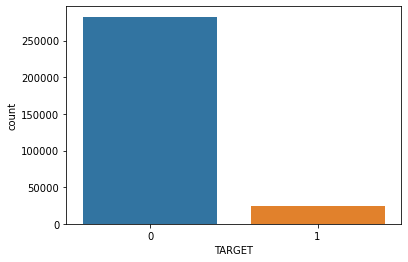

In [25]:
#データが返済に偏っているのまき→割合で見る方がいい
sns.countplot(train['TARGET'])

ここで、trainのカラムを見返してみる  
今回は、仮説を立てるに当たり、全ての変量をみるのは大変なので  
顧客側のローンの情報と相関がありそうな金銭や資産・負債に的を絞ってみる

In [26]:
train.columns.values

array(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE',
       'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE',
       'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE',
       'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START',
       'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION',
       'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
       'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
       'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_1',
       'EXT_SOURCE_2', 'EXT_SOURCE_3',

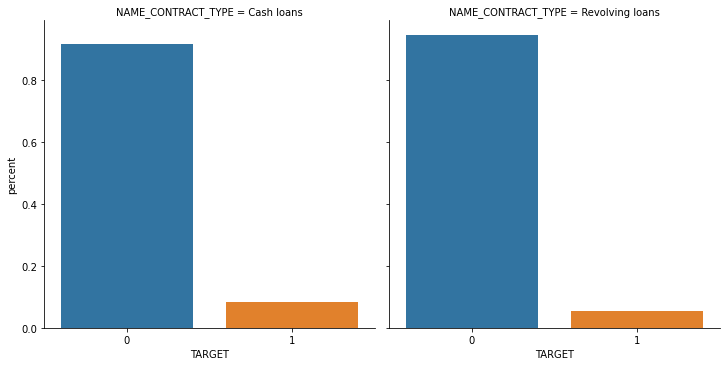

In [27]:
#ローンの種類による影響ははあまりない？
data_loan = (train.groupby('NAME_CONTRACT_TYPE')['TARGET']
             .value_counts(normalize=True)
             .rename('percent')
             .reset_index())
sns.catplot(
    x='TARGET',
    y="percent",
    col_order=train['NAME_CONTRACT_TYPE'].unique(),
    order=[0,1],
    col='NAME_CONTRACT_TYPE',
    data=data_loan,
    kind="bar"
)

In [28]:
data_loan

,NAME_CONTRACT_TYPE,TARGET,percent
0,Cash loans,0,0.92
1,Cash loans,1,0.08
2,Revolving loans,0,0.95
3,Revolving loans,1,0.05


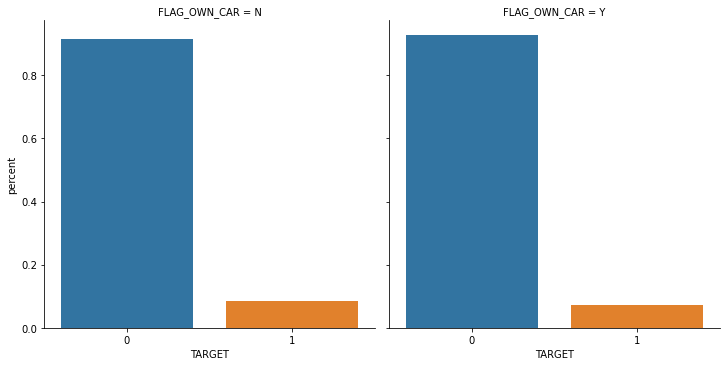

In [29]:
#車や不動産を持っているとどうか？　

data_car = (train.groupby('FLAG_OWN_CAR')['TARGET']
             .value_counts(normalize=True)
             .rename('percent')
             .reset_index())
sns.catplot(
    x='TARGET',
    y="percent",
    col_order=train['FLAG_OWN_CAR'].unique(),
    order=[0,1],
    col='FLAG_OWN_CAR',
    data=data_car,
    kind="bar"
)

In [60]:
data_car

,FLAG_OWN_CAR,TARGET,percent
0,N,0,0.91
1,N,1,0.09
2,Y,0,0.93
3,Y,1,0.07


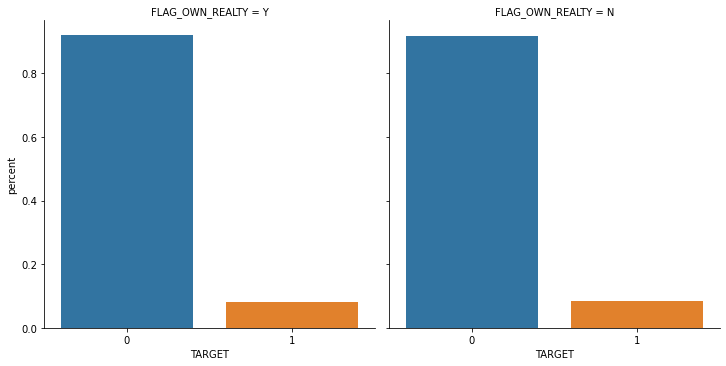

In [63]:
data_reality = (train.groupby('FLAG_OWN_REALTY')['TARGET']
             .value_counts(normalize=True)
             .rename('percent')
             .reset_index())
sns.catplot(
    x='TARGET',
    y="percent",
    col_order=train['FLAG_OWN_REALTY'].unique(),
    order=[0,1],
    col='FLAG_OWN_REALTY',
    data=data_reality,
    kind="bar"
)

In [64]:
data_reality

,FLAG_OWN_REALTY,TARGET,percent
0,N,0,0.92
1,N,1,0.08
2,Y,0,0.92
3,Y,1,0.08


<AxesSubplot:>

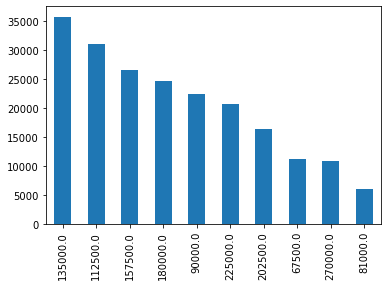

In [94]:
#収入はどうか？
#平均よりやや低いくらいに人数が多い
train['AMT_INCOME_TOTAL'].value_counts().head(10).plot.bar()

In [113]:
train['AMT_INCOME_TOTAL'].describe()

count      307511.00
mean       168797.92
std        237123.15
min         25650.00
25%        112500.00
50%        147150.00
75%        202500.00
max     117000000.00
Name: AMT_INCOME_TOTAL, dtype: float64

全部で見るとガバガバになるので4分位範囲で見てみる


<AxesSubplot:xlabel='TARGET', ylabel='AMT_INCOME_TOTAL'>

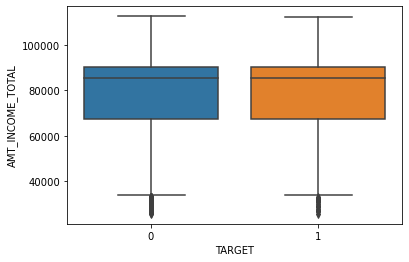

In [109]:
#箱ひげ図を見てみる 
#第1
sns.boxplot(
    x='TARGET',
    y='AMT_INCOME_TOTAL',
    data=train.query('25650.00 <= AMT_INCOME_TOTAL< 112500.00')
)

<AxesSubplot:xlabel='TARGET', ylabel='AMT_INCOME_TOTAL'>

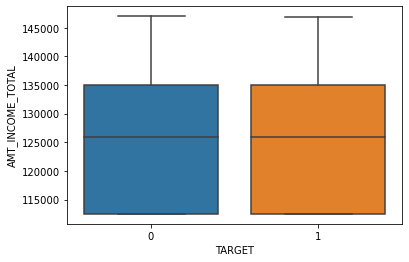

In [110]:
#第2
sns.boxplot(
    x='TARGET',
    y='AMT_INCOME_TOTAL',
    data=train.query('112500.00<=AMT_INCOME_TOTAL<147150.00')
)

<AxesSubplot:xlabel='TARGET', ylabel='AMT_INCOME_TOTAL'>

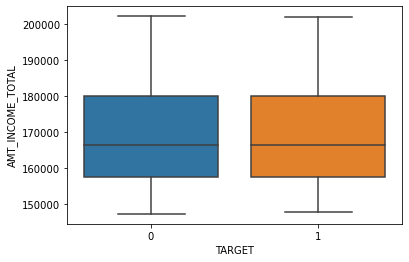

In [117]:
#第3
sns.boxplot(
    x='TARGET',
    y='AMT_INCOME_TOTAL',
    data=train.query('147150.00<=AMT_INCOME_TOTAL<202500.00')
)

<AxesSubplot:xlabel='TARGET', ylabel='AMT_INCOME_TOTAL'>

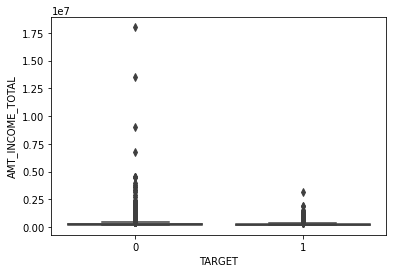

In [287]:
#第四　　0の方が多そう
sns.boxplot(
    x='TARGET',
    y='AMT_INCOME_TOTAL',
    data=train.query('202500.00<=AMT_INCOME_TOTAL<=18000090.00')
)

当たり前だけど、収入が高い人ほど、よく返してそう  
基準は202500.00以上の人は0といえそう(ルールベースその1) 

<AxesSubplot:>

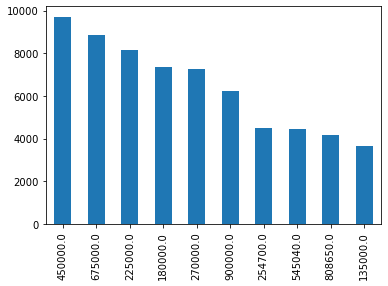

In [121]:
#融資額はどうか
#450000に多い
train['AMT_CREDIT'].value_counts().head(10).plot.bar()

In [162]:
train['AMT_CREDIT'].describe()

count    307511.00
mean     599026.00
std      402490.78
min       45000.00
25%      270000.00
50%      513531.00
75%      808650.00
max     4050000.00
Name: AMT_CREDIT, dtype: float64

<AxesSubplot:xlabel='TARGET', ylabel='AMT_CREDIT'>

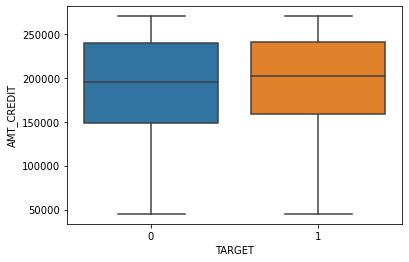

In [170]:
#第1

sns.boxplot(
    x='TARGET',
    y='AMT_CREDIT',
    data=train.query('45000.00 <= AMT_CREDIT< 270000.00')
)

<AxesSubplot:xlabel='TARGET', ylabel='AMT_CREDIT'>

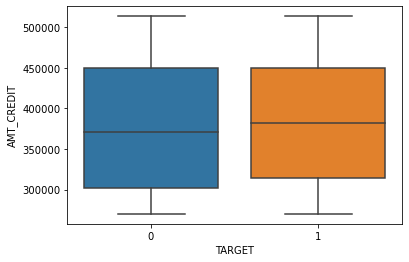

In [171]:
# 第2
sns.boxplot(
    x='TARGET',
    y='AMT_CREDIT',
    data=train.query('270000.00 <= AMT_CREDIT< 513531.00')
)

<AxesSubplot:xlabel='TARGET', ylabel='AMT_CREDIT'>

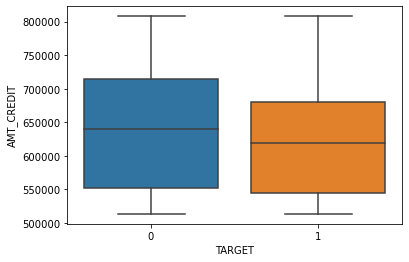

In [172]:
# 第3
#返している人は多く借りている傾向がある？
sns.boxplot(
    x='TARGET',
    y='AMT_CREDIT',
    data=train.query('513531.00 <= AMT_CREDIT< 808650.00')
)

<AxesSubplot:xlabel='TARGET', ylabel='AMT_CREDIT'>

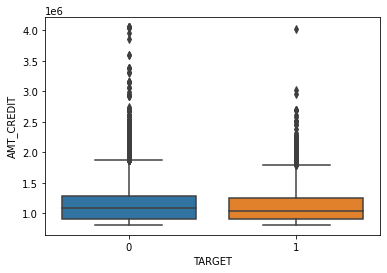

In [288]:
# 第4
#返している人は多く借りている傾向がありそう 
sns.boxplot(
    x='TARGET',
    y='AMT_CREDIT',
    data=train.query('808650.00<= AMT_CREDIT<= 4050000.00')
)

高く借りている人の方がよりしっかり返してそう  
その特徴が出てくるのは、808650.00以上が一旦0と考える(ルールベースその2) 

<AxesSubplot:>

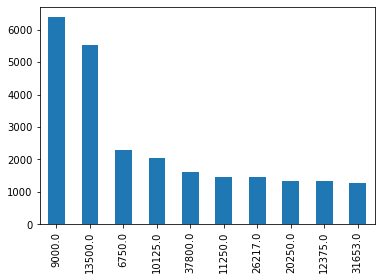

In [160]:
#年金の一種である種の投資的なものANNUITY
train['AMT_ANNUITY'].value_counts().head(10).plot.bar()

In [164]:
train['AMT_ANNUITY'].describe()

count   307499.00
mean     27108.57
std      14493.74
min       1615.50
25%      16524.00
50%      24903.00
75%      34596.00
max     258025.50
Name: AMT_ANNUITY, dtype: float64

<AxesSubplot:xlabel='TARGET', ylabel='AMT_ANNUITY'>

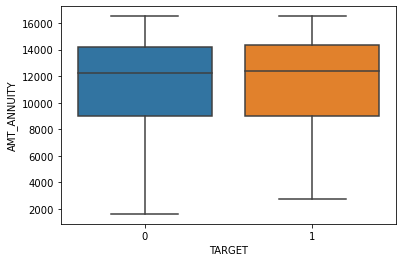

In [174]:
#第1
sns.boxplot(
    x='TARGET',
    y='AMT_ANNUITY',
    data=train.query('1615.50 <= AMT_ANNUITY< 16524.00')
)

<AxesSubplot:xlabel='TARGET', ylabel='AMT_ANNUITY'>

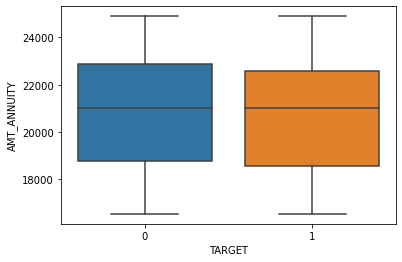

In [175]:
#第2
sns.boxplot(
    x='TARGET',
    y='AMT_ANNUITY',
    data=train.query('16524.00 <= AMT_ANNUITY< 24903.00')
)

<AxesSubplot:xlabel='TARGET', ylabel='AMT_ANNUITY'>

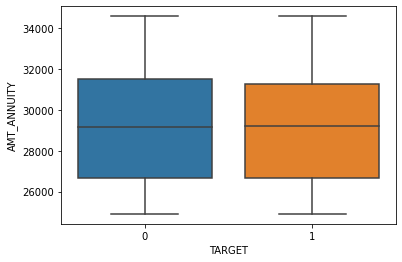

In [176]:
#第3
sns.boxplot(
    x='TARGET',
    y='AMT_ANNUITY',
    data=train.query('24903.00 <= AMT_ANNUITY< 34596.00')
)

<AxesSubplot:xlabel='TARGET', ylabel='AMT_ANNUITY'>

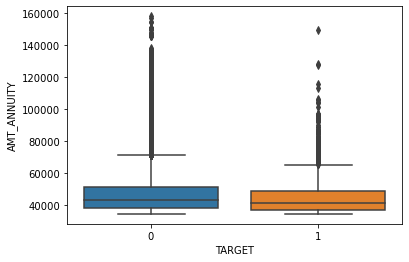

In [289]:
#第4 難しいけどこれも金額が多い方が0によりそう
sns.boxplot(
    x='TARGET',
    y='AMT_ANNUITY',
    data=train.query('34596.00 <= AMT_ANNUITY< 158025.50')
)

投資額高い人の方がよく返してそう  
その特徴が出てくるのは、34596.00以上が一旦0と考える(ルールベースその3) 

- まとめ
 1. ローンの種類や資産は、返す返さないにあまり影響がなさそう
 2. 収入が202500.00以上以上が一旦0と考える(ルールベースその1)
 3. 融資額が808650.00以上が一旦0と考える(ルールベースその2)
 4. 投資額が34596.00以上が一旦0と考える(ルールベースその3)

In [54]:
#ルールベースによる3つのモデル作り
X = train[train.columns[train.columns != 'TARGET']]
y = train.TARGET

In [64]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1,random_state=0)

In [65]:
X_test["pred_class_income"] = list(map(lambda x:x<=202500.00,X_test['AMT_INCOME_TOTAL']))
X_test["pred_class_income"] = X_test['pred_class_income'].astype(int)

<ipython-input-65-fab7ccc7720b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test["pred_class_income"] = list(map(lambda x:x<=202500.00,X_test['AMT_INCOME_TOTAL']))
<ipython-input-65-fab7ccc7720b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test["pred_class_income"] = X_test['pred_class_income'].astype(int)


In [66]:
#低い　現状のINCOMEの数にひきづられてそう
from sklearn.metrics import accuracy_score
accuracy_score(y_test, X_test["pred_class_income"]) 

0.28121748178980227

In [355]:
X_test["pred_class_income"]

237185    1
209148    1
80040     0
55965     1
120348    1
         ..
272951    1
214771    1
184925    1
189006    1
46060     1
Name: pred_class_income, Length: 92254, dtype: int64

In [48]:
X_test["pred_class_AMT_CREDIT"] = list(map(lambda x:x<=808650.00,X_test['AMT_CREDIT']))
X_test["pred_class_AMT_CREDIT"] = X_test['pred_class_AMT_CREDIT'].astype(int)

<ipython-input-48-d4164fb5ddf6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test["pred_class_AMT_CREDIT"] = list(map(lambda x:x<=808650.00,X_test['AMT_CREDIT']))
<ipython-input-48-d4164fb5ddf6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test["pred_class_AMT_CREDIT"] = X_test['pred_class_AMT_CREDIT'].astype(int)


In [49]:
#低い・・・
accuracy_score(y_test, X_test["pred_class_AMT_CREDIT"])

0.29253381893860564

In [358]:
#低い
X_test["pred_class_AMT_ANNUITY"] = list(map(lambda x:x<=34596.00,X_test['AMT_ANNUITY']))
X_test["pred_class_AMT_ANNUITY"] = X_test['pred_class_AMT_ANNUITY'].astype(int)
accuracy_score(y_test, X_test["pred_class_AMT_ANNUITY"])

<ipython-input-358-0de3a0c47b07>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test["pred_class_AMT_ANNUITY"] = list(map(lambda x:x<=34596.00,X_test['AMT_ANNUITY']))
<ipython-input-358-0de3a0c47b07>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test["pred_class_AMT_ANNUITY"] = X_test['pred_class_AMT_ANNUITY'].astype(int)


0.293721681444707

In [401]:
#全ての条件を組み合わせたらどうなるか 多数決で取得 X_testの中で、上記3つを行方向に足して0か1ならば0、2か3ならば1を返す
X_test['cal'] = X_test[['pred_class_income','pred_class_AMT_CREDIT','pred_class_AMT_ANNUITY']].sum(axis=1)
X_test = X_test.reset_index().drop('index',axis=1)

<ipython-input-401-274226724e89>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['cal'] = X_test[['pred_class_income','pred_class_AMT_CREDIT','pred_class_AMT_ANNUITY']].sum(axis=1)


In [402]:
X_test['cal']

0        3
1        3
2        2
3        3
4        3
        ..
92249    3
92250    1
92251    1
92252    1
92253    3
Name: cal, Length: 92254, dtype: int64

In [414]:
a=[]
for x in range(len(X_test['cal'])):
    if X_test.loc[x,'cal'] <= 1:
        a.append(0)
    else:
        a.append(1)
X_test['all'] = a

In [416]:
#多数決でもあまり効果はなかった
accuracy_score(y_test, X_test["all"])

0.2728011793526568

## light GBMを用いて、重要度が0のものを削除

- 0と1を判別する境界線の閾値が間違っていたと考えられる
- light bgm(決定木と勾配ブースティングを掛け合わせたもの)を用いて、使える特徴量を一旦決めてみる
- light bgmはブースティングを行い、弱学習器を繋げていく  
- light gbmは目的関数を2次近似するニュートンブースティングの考え方を使っている

In [4]:
#trainデータのみを利用してみる、まずは前処理を
from sklearn.preprocessing import OrdinalEncoder
oe = OrdinalEncoder()
def data_pre(df):
    nonull_list = []
    for col in df.columns:
        nonull = df[col].count()
        if nonull == 0:
            nonull_list.append(col)
    df = df.drop(nonull_list,axis=1) #全てnullのデータを削除
    df = df.drop("SK_ID_CURR",axis=1)
    df_number = df.select_dtypes('number') #数値データのみを抽出
    df_number = pd.DataFrame(df_number.fillna(-999),columns=df_number.columns) #Light　GBMは分岐を行うため、欠損値は同じとこに分岐させるような数を入れる
    df_object = df.select_dtypes('object')
    df_object = df_object.fillna('Null') #カテゴリ変数はNullで埋める
    df_object = pd.DataFrame(oe.fit_transform(df_object.values),columns=df_object.columns)
    df = pd.concat([df_number,df_object],axis=1)
    return df

lightGBM参考：https://potesara-tips.com/lightgbm-feature-importance/  
https://mathmatical22.xyz/2020/04/09/%E3%80%90%E5%88%9D%E5%AD%A6%E8%80%85%E5%90%91%E3%81%91%E3%80%91lightgbm-%E5%9F%BA%E6%9C%AC%E7%9A%84%E3%81%AA%E4%BD%BF%E3%81%84%E6%96%B9-%E5%9B%9E%E5%B8%B0%E5%88%86%E6%9E%90%E7%B7%A8%E3%80%90python/

In [5]:
train_inv = data_pre(train)

In [6]:
X_train_inv = train_inv[train_inv.columns[train_inv.columns != 'TARGET']]

In [7]:
X_train_inv

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE
0,0,202500.00,406597.50,24700.50,351000.00,0.02,-9461,-637,-3648.00,-2120,...,4.00,3.00,1.00,8.00,6.00,5.00,3.00,1.00,6.00,0.00
1,0,270000.00,1293502.50,35698.50,1129500.00,0.00,-16765,-1188,-1186.00,-291,...,1.00,1.00,1.00,3.00,1.00,39.00,3.00,1.00,0.00,0.00
2,0,67500.00,135000.00,6750.00,135000.00,0.01,-19046,-225,-4260.00,-2531,...,4.00,3.00,1.00,8.00,1.00,11.00,0.00,0.00,3.00,1.00
3,0,135000.00,312682.50,29686.50,297000.00,0.01,-19005,-3039,-9833.00,-2437,...,4.00,0.00,1.00,8.00,6.00,5.00,0.00,0.00,3.00,1.00
4,0,121500.00,513000.00,21865.50,513000.00,0.03,-19932,-3038,-4311.00,-3458,...,4.00,3.00,1.00,3.00,4.00,37.00,0.00,0.00,3.00,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,0,157500.00,254700.00,27558.00,225000.00,0.03,-9327,-236,-8456.00,-1982,...,4.00,2.00,5.00,15.00,4.00,43.00,3.00,1.00,6.00,0.00
307507,0,72000.00,269550.00,12001.50,225000.00,0.03,-20775,365243,-4388.00,-4090,...,4.00,5.00,1.00,12.00,1.00,57.00,3.00,1.00,6.00,0.00
307508,0,153000.00,677664.00,29979.00,585000.00,0.01,-14966,-7921,-6737.00,-5150,...,1.00,2.00,1.00,10.00,4.00,39.00,3.00,1.00,5.00,0.00
307509,0,171000.00,370107.00,20205.00,319500.00,0.01,-11961,-4786,-2562.00,-931,...,4.00,1.00,1.00,8.00,6.00,3.00,0.00,1.00,6.00,0.00


In [8]:
y_train_inv = train_inv['TARGET']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_train_inv, y_train_inv,
                                                    test_size=0.2,
                                                    random_state=0,
                                                    stratify=y_train_inv)

In [10]:
X_train, X_eval, y_train, y_eval = train_test_split(X_train, y_train,
                                                    test_size=0.2,
                                                    random_state=1,
                                                    stratify=y_train)

In [11]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_eval, y_eval, reference=lgb_train)

In [12]:
params = {'task': 'train',                # 学習、トレーニング ⇔　予測predict
          'boosting_type': 'gbdt',        # 勾配ブースティング
          'objective': 'multiclass',      # 目的関数：多値分類、マルチクラス分類　回帰なら'regression'
          'metric': 'multi_logloss',      # 分類モデルの性能を測る指標
          'num_class': 3,                 # 目的変数のクラス数
          'learning_rate': 0.02,          # 学習率（初期値0.1）
          'num_leaves': 23,               # 決定木の複雑度を調整（初期値31）
          'min_data_in_leaf': 1,          # データの最小数（初期値20）
         }

In [13]:
evaluation_results = {}                                     # 学習の経過を保存する箱
model = lgb.train(params, # パラメータ
            train_set=lgb_train,
            num_boost_round=1000, # トレーニングデータの指定
            valid_sets=lgb_eval,
            evals_result=evaluation_results,
            early_stopping_rounds=100,
            verbose_eval=10
               )

/Users/isomasaki/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/isomasaki/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/isomasaki/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037057 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11378
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 119
[LightGBM] [Info] Start training from score -0.084175
[LightGBM] [Info] Start training from score -2.516654
[LightGBM] [Info] Start training from score -34.538776
Training until validation scores don't improve for 100 rounds
[10]	valid_0's multi_logloss: 0.270853
[20]	valid_0's multi_logloss: 0.265275
[30]	valid_0's multi_logloss: 0.261652
[40]	valid_0's multi_logloss: 0.259069
[50]	valid_0's multi_logloss: 0.257143
[60]	valid_0's multi_logloss: 0.255756
[70]	valid_0's multi_logloss: 0.254618
[80]	valid_0's multi_logloss: 0.253721
[90]	valid_0's multi_logloss: 0.252956
[100]	valid_0's multi_logloss: 0.252337
[110]	valid_0's multi_log

In [14]:
optimum_boost_rounds = model.best_iteration

In [15]:
y_pred = model.predict(X_test, num_iteration=model.best_iteration)
y_pred_max = np.argmax(y_pred, axis=1)

In [16]:
accuracy = sum(y_test == y_pred_max) / len(y_test)
print('accuracy:', accuracy)

accuracy: 0.9201014584654407


In [18]:
#importanca_type = gainを選択すると、どれくらい目的関数の減少に寄与しているかがわかる
importance = pd.DataFrame(model.feature_importance(importance_type='gain'), index=X_train_inv.columns, columns=['importance'])
importance = importance.sort_values('importance', ascending=False)
importance.index.values

array(['EXT_SOURCE_3', 'EXT_SOURCE_2', 'EXT_SOURCE_1', 'DAYS_BIRTH',
       'AMT_CREDIT', 'AMT_ANNUITY', 'DAYS_EMPLOYED', 'AMT_GOODS_PRICE',
       'DAYS_ID_PUBLISH', 'NAME_EDUCATION_TYPE', 'DAYS_LAST_PHONE_CHANGE',
       'AMT_INCOME_TOTAL', 'DAYS_REGISTRATION', 'CODE_GENDER',
       'OWN_CAR_AGE', 'REGION_POPULATION_RELATIVE',
       'HOUR_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FLAG_DOCUMENT_3',
       'AMT_REQ_CREDIT_BUREAU_YEAR', 'OCCUPATION_TYPE',
       'NAME_INCOME_TYPE', 'NAME_FAMILY_STATUS',
       'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'APARTMENTS_AVG', 'NAME_CONTRACT_TYPE',
       'YEARS_BEGINEXPLUATATION_AVG', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'WEEKDAY_APPR_PROCESS_START', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'REGION_RATING_CLIENT_W_CITY', 'BASEMENTAREA_AVG',
       'TOTALAREA_MODE', 'NONLIVINGAREA_AVG', 'LANDAREA_AVG',
       'CNT_CHILDREN', 'FLOORSMAX_AVG', 'FLAG_OWN_CAR',
       'NAME_HOUSING_TYPE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'YEARS_BUILD_A

※importanceのgainは、入力変数ごとに決定木回帰の変数重要度の平均をとったもの

In [19]:
importance

,importance
EXT_SOURCE_3,125341.14
EXT_SOURCE_2,111509.03
EXT_SOURCE_1,34119.49
DAYS_BIRTH,30772.38
AMT_CREDIT,20467.04
...,...
FLAG_DOCUMENT_17,31.33
FLAG_DOCUMENT_12,0.00
FLAG_DOCUMENT_4,0.00
FLAG_DOCUMENT_10,0.00


In [20]:
importance = importance.reset_index()
importance.columns = ['name','importance']

In [21]:
drop_list = list(importance.query('importance == 0').name)

In [22]:
drop_list

['FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_10', 'FLAG_MOBIL']

<b>TOP10の解釈</b>  
- EXT_SOURCEのimportanceが高くなっているが、外部からのデータとあるが不明→削除
- 次点でDAYS_BIRTHで生まれが関係ある？年齢が高いほどよく返すことができるなどと予想できる
- AMT_CREDITは先述した通りだが、ルールベースでは金額の閾値を変更したい
- AMT_ANNUITYも先述した通りだが、ルールベースでは金額の閾値を変更したい
- DAYS_EMPLOYEDは、なるほど。仕事がないとお金返せないからね
- AMT_GOODS_PRICEは前回の申込時に顧客が希望した商品の価格なので、高ければ返せなさそう
- DAYS_ID_PUBLISH申請の何日前に、身分証を変更したかなので、おそらく直接的な関係はなさそう（疑似相関）
- NAME_EDUCATION_TYPEは、学歴が高いほど収入が高そうなので、よく返済できそう
- DAYS_LAST_PHONE_CHANGEは、申し込みの何日前に携帯電話を変更したか、これも直接的な関係はなさそう
- AMT_INCOME_TOTALこれこそ一番関係ありそうだけど、順位は下の方
- DAYS_REGISTRATION?? 登録変更日

EXT_SOURCEとimportanceが0のものを削除

In [23]:
train = train.drop(train[['EXT_SOURCE_3','EXT_SOURCE_2','EXT_SOURCE_1']],axis=1)
train = train.drop(drop_list,axis=1)

In [24]:
#元データからいらないものをスッキリ削除
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.00,406597.50,24700.50,...,0,0,0,0,0.00,0.00,0.00,0.00,0.00,1.00
1,100003,0,Cash loans,F,N,N,0,270000.00,1293502.50,35698.50,...,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00
2,100004,0,Revolving loans,M,Y,Y,0,67500.00,135000.00,6750.00,...,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00
3,100006,0,Cash loans,F,N,Y,0,135000.00,312682.50,29686.50,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.00,513000.00,21865.50,...,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00


In [25]:
#null値の処理 ：　nullを含んでおりimportanceが低い列を削除
b = pd.DataFrame(train.isnull().sum().reset_index())
b.columns  = ['name','num']
c = b.query('num != 0 ')
#nullを含む列のcとimportanceの比較
compare = pd.merge(importance,c,how='inner',on='name')
#compareのimportanceを考慮したnull値の数
np.average(
    a=compare.num,
    weights= compare.importance
          )

84748.03451500808

In [26]:
#加重平均以上のnull値を含む項目を削除
drop_list_2 = list(compare.query('num >= 84748').name)

In [27]:
drop_list_2

['OWN_CAR_AGE',
 'OCCUPATION_TYPE',
 'APARTMENTS_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'BASEMENTAREA_AVG',
 'TOTALAREA_MODE',
 'NONLIVINGAREA_AVG',
 'LANDAREA_AVG',
 'FLOORSMAX_AVG',
 'YEARS_BUILD_AVG',
 'ENTRANCES_AVG',
 'COMMONAREA_AVG',
 'LIVINGAREA_AVG',
 'WALLSMATERIAL_MODE',
 'APARTMENTS_MODE',
 'LANDAREA_MODE',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAREA_MODE',
 'YEARS_BEGINEXPLUATATION_MODE',
 'LIVINGAPARTMENTS_AVG',
 'BASEMENTAREA_MODE',
 'LIVINGAPARTMENTS_MODE',
 'COMMONAREA_MODE',
 'LIVINGAREA_MEDI',
 'ELEVATORS_AVG',
 'YEARS_BUILD_MODE',
 'FLOORSMIN_AVG',
 'LIVINGAREA_MODE',
 'FONDKAPREMONT_MODE',
 'APARTMENTS_MEDI',
 'NONLIVINGAREA_MEDI',
 'NONLIVINGAPARTMENTS_MODE',
 'BASEMENTAREA_MEDI',
 'LIVINGAPARTMENTS_MEDI',
 'ENTRANCES_MODE',
 'COMMONAREA_MEDI',
 'FLOORSMAX_MODE',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'HOUSETYPE_MODE',
 'EMERGENCYSTATE_MODE',
 'LANDAREA_MEDI',
 'FLOORSMIN_MODE',
 'ELEVATORS_MODE',
 'NONLIVINGAPARTMENTS_MEDI',
 'YEARS_BUILD_MEDI',
 'ELEVATORS_MEDI',
 'F

In [28]:
train = train.drop(drop_list_2,axis=1)

In [29]:
train

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.00,406597.50,24700.50,...,0,0,0,0,0.00,0.00,0.00,0.00,0.00,1.00
1,100003,0,Cash loans,F,N,N,0,270000.00,1293502.50,35698.50,...,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00
2,100004,0,Revolving loans,M,Y,Y,0,67500.00,135000.00,6750.00,...,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00
3,100006,0,Cash loans,F,N,Y,0,135000.00,312682.50,29686.50,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.00,513000.00,21865.50,...,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.00,254700.00,27558.00,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307507,456252,0,Cash loans,F,N,Y,0,72000.00,269550.00,12001.50,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307508,456253,0,Cash loans,F,N,Y,0,153000.00,677664.00,29979.00,...,0,0,0,0,1.00,0.00,0.00,1.00,0.00,1.00
307509,456254,1,Cash loans,F,N,Y,0,171000.00,370107.00,20205.00,...,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00


## ランダムフォレストでモデリング(決定木×バギング)

In [30]:
target_train = train['TARGET']
train = train.drop('TARGET',axis=1)

In [31]:
train

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,Cash loans,M,N,Y,0,202500.00,406597.50,24700.50,351000.00,...,0,0,0,0,0.00,0.00,0.00,0.00,0.00,1.00
1,100003,Cash loans,F,N,N,0,270000.00,1293502.50,35698.50,1129500.00,...,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00
2,100004,Revolving loans,M,Y,Y,0,67500.00,135000.00,6750.00,135000.00,...,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00
3,100006,Cash loans,F,N,Y,0,135000.00,312682.50,29686.50,297000.00,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,Cash loans,M,N,Y,0,121500.00,513000.00,21865.50,513000.00,...,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,Cash loans,M,N,N,0,157500.00,254700.00,27558.00,225000.00,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307507,456252,Cash loans,F,N,Y,0,72000.00,269550.00,12001.50,225000.00,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307508,456253,Cash loans,F,N,Y,0,153000.00,677664.00,29979.00,585000.00,...,0,0,0,0,1.00,0.00,0.00,1.00,0.00,1.00
307509,456254,Cash loans,F,N,Y,0,171000.00,370107.00,20205.00,319500.00,...,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00


In [32]:
target_train

0         1
1         0
2         0
3         0
4         0
         ..
307506    0
307507    0
307508    0
307509    1
307510    0
Name: TARGET, Length: 307511, dtype: int64

In [33]:
#ランダムフォレストは数字自体の大きさを考慮しないので、ラベルエンコーディングを行う
train_data = data_pre(train)

- ランダムフォレスト(分類木のバギング)を用いて、分類を行っていく  
- 決定木とはCARTの場合、目的変数yのジニ不純度から各変数の条件付きジニ不純度を引いたジニ利得が最大の変数を選んでいく
- バギングとは説明変数データをブートストラップ手法によって重複を許して抽出し、それぞれの説明変数データに対して分類木によって算出する  
  その分類木たちの多数決をとり、もっとも精度の大きいものを選択する

- ランダムフォレスト（値の個数に依存するため、値自体の大小関係に意味はないからスケーリングはしない）
  1. ブートストラップ手法で、データを作成
  2. データごとに決定木の実装
  3. 決定木同士の多数決をとる

In [55]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,cross_validate,KFold
from sklearn.model_selection import RandomizedSearchCV
X_train,X_test,y_train,y_test = train_test_split(train_data,target_train,test_size=0.3)
rfc = RandomForestClassifier(max_depth=30,n_estimators=100,random_state=0)
res_cv = cross_validate(rfc,X=X_train,y=y_train,scoring="accuracy",cv=KFold(n_splits=5,shuffle=True),
                       return_train_score=True)
res_cv

{'fit_time': array([31.99391103, 31.87915897, 32.24020481, 31.83231211, 31.81589985]),
 'score_time': array([0.82104611, 0.79261589, 0.85669518, 0.79653502, 0.80598712]),
 'test_score': array([0.9196553 , 0.91963207, 0.91821328, 0.91672667, 0.91990895]),
 'train_score': array([0.99740426, 0.9971081 , 0.99670162, 0.99713134, 0.99722425])}

In [56]:
#テストデータでの正答率の平均値と標準偏差
res_cv['test_score'].mean(),res_cv['test_score'].std()

(0.9188272547101185, 0.0012077129238420913)

In [54]:
#ランダムサーチでmax_depthを探索
from sklearn.model_selection import RandomizedSearchCV
rfc_r = RandomForestClassifier(n_estimators=100,random_state=0)
param = {'max_depth':[10,20,30,40,50]}
model_r = RandomizedSearchCV(estimator=rfc_r,param_distributions=param,cv=KFold(n_splits=5,shuffle=True),scoring="accuracy",
                            n_jobs=-1)
model_r.fit(X_train,y_train)
model_r.best_params_

/Users/isomasaki/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/isomasaki/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


{'max_depth': 30}

In [64]:
rfc.fit(X_train,y_train)

RandomForestClassifier(max_depth=30, random_state=0)

In [65]:
pred = rfc.predict(X_test)

In [75]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,pred)

0.9203286578359746

<BarContainer object of 10 artists>

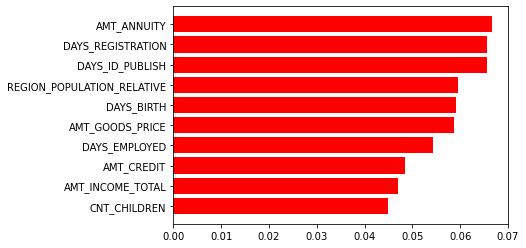

In [96]:
#TOP10の重要度の表示
importance_r = rfc.feature_importances_
importance_r = importance_r[np.argpartition(importance_r, -10)[-10:]]
indices = np.argsort(importance_r)
plt.barh(np.asarray(X_train.columns)[indices],importance_r[indices],color="r",align='center')

In [97]:
importance_r

array([0.04491097, 0.04694058, 0.04844594, 0.0666893 , 0.05877015,
       0.05949006, 0.05919343, 0.05435196, 0.06566052, 0.06550322])

総括：
- ルールベースでも触れた、投資額がもっとも大きく関連していることがわかった (ただし、AMTとつく項目の疑似相関はきにすべき)  
  →仮説として、お金にまつわる項目は重要度が高く、互いに相関しやすいと考えるのが自然
- 登録日とID発行日については関連を調べる必要がありそう
- この結果はともかく因果関係をはっきりさせる必要はある